# Lumped Parameter Model 

Adaptado de Xiao et al (2013) Lumped parameter model for charge–discharge cycle of adsorptive
hydrogen storage system

Autor: Kieran Conradie


Las ecuaciones que gobiernan el sistema propuesto en el artículo son: 

Masa:
$$ \frac{dm_t}{dt}=\dot{m_i}-\dot{m_e}$$
Las cual puede ser separada en dos casos:
    
1. Carga: $\frac{dm_t}{dt}=\dot{m_i}$
2. Descarga: $\frac{dm_t}{dt}=-\dot{m_e}$ 

Dentro de las ecuaciones de masa existen otras que ayudan a especificar el problema: 
$$m_t = m_g + m_a$$
$$m_a = n_a M_{H_2} m_s$$

Donde los moles de hidrógeno adsorbido están dados por:
$$n_a = n_0 \exp\left[-\left(\frac{RT}{\alpha + \beta T}\right)^b \ln{\left(\frac{p_0}{p}\right)}^b\right]$$
y la presión esta dada por:
$$p=\frac{(m-m_a)ZRT}{M_{H_2}V\epsilon_b}$$

Temperatura:
$$\frac{dT}{dt}=\frac{\dot{m_i}h_i - \dot{m_e}h_e + \frac{dm_a}{dt}\frac{\Delta{H}}{M_{H_2}}-h_fA_e(T-T_f)}{m_sc_s+m_ac_{va}+m_gc_{vg}+m_wc_w}$$

La derivación de $\frac{\partial n_a}{\partial t}$ se realizó mediante wolfram mathematica

In [1]:
# Integración numérica de sistemas de ecuaciones diferenciales ordinarias
from scipy.integrate import solve_ivp

# Minimización de funciones objetivos para ajuste de parámetros
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt
import copy

### Definición de la función con el sistema de ecuaciones diferenciales

In [2]:
# Por el momento la función solo trabajara para el proceso de carga, después se le podria dar un parametro mas a la función 
# que use un kwarg del tipo proceso = carga/descarga y en base a eso realizar cálculos
def adsorcion_hidrogeno(t, y, c_s, c_p, c_w, m_s, m_w, M_H2, R, alpha, beta, epsilon, volumen, area, p_0, n_0, b, m_dot, h, h_f, T_f):
    
    # Desempacar variables
    n_a = y[0] # Isoterma de adsorcion 
    T = y[1] # Temperatura 
    p = y[2] # Presión
    
    
    # Inicializar variables como las masas (m_t, m_a, m_g) y la presión (Valor dado por las condiciones iniciales)
    
    # La masa total se puede calcular directamente si se conoce m_dot(t)
    m_t = m_dot * t

    # Buena practica debugging, graficar variables intermedias
    print(f'La masa total del sistema es {m_t}')

    # n_a = 0 # Al empezar vacio la masa adsorbida también debe ser 0, quizas se pueda usar para un tiempo "Justo" después de t = 0 s
    print("n_a: ", n_a)
    m_a = M_H2*m_s*n_a
    
    # masa libre de hidrógeno
    m_g = m_t - m_a # Relación dada en el artículo

    
    # Calcular cantidades dependientes de las variables independientes
    # n_a = n_0 * np.exp(-((R*T)/(alpha + beta*T))**b * np.log(p_0/p)**b)
    dH = alpha * (np.log(p_0/p))**(1/b)
    
    # Como todas las ecuaciones dependen una de la otra se declara un valor para dn_dt y dp_dt inicial
    # Se elije resolver primero para dT_dt ya que solo depende de dn_dt y no de dp
    
    dp_dt = 0#1e-3 # Se necesita para calcular dn_dt
    dn_dt = 0#1e-4 # Se necesita para calcular dT_dt
    
    
    # Se usaron los siguientes cambios de variable para simplificar la escritura del script:
    theta = alpha + beta*T
    xi = np.log(p_0/p)
    zeta = R*T
    
    sw = False
    
    # for i in range(10):
        # Por el momento asumir que c_v = c_p para el hidrogeo (Solo por flojera, después se debe usar una correlación)
    dT_dt = (m_dot*h + M_H2*m_s*dn_dt - h_f*area*(T-T_f))/(m_s*c_s + m_a*c_p + m_g*c_p + m_w*c_w)

    # Ecuación diferencial para la presión
    dp_dt = R/(M_H2*epsilon*volumen) * (M_H2*m_s*dn_dt + dT_dt) 
    print(f'Presion: {p}')
    print(f'dp_dt: {dp_dt}')

        # Ecuación diferencial para la isoterma
    if sw:
        dn_dt = (m_t*n_a*(((R*T)/(alpha+beta*T))*np.log(p_0/p))**b * 
             ((1/np.log(p_0/p))*(1/p)*dp_dt - (alpha/(alpha+beta*T))*(1/T)*dT_dt))
    else:
        print(f'theta: {theta}')
        print(f'Temperatura: {T}')
        dn_dt = (b * np.exp(-(zeta*xi)/(theta))**b * n_0*zeta*((zeta*xi)/theta)**(-1+b) * dp_dt 
                 - b * np.exp(-(zeta*xi)/(theta))**b * n_0*zeta*((zeta*xi)/theta)**(-1+b) * ((zeta*beta*xi)/(theta**2) 
                                                                                             + (R*xi)/(theta)) * dT_dt)
    
    tol = 10e-6 # Tolerancia para encontrar la mejor aproximación para las funciones
    
    # Esto estaba en cero pero se debe inicializar mayor que uno, de otra manera
    # nunca entra al loop
    dif = 10 

    # Número de loops realizados (Para debugear)
    n = 0

    # while dif > tol :
        
        # Almacenar los valores de la iteración anterior
    dT_dt_old = copy.deepcopy(dT_dt) 
    dp_dt_old = copy.deepcopy(dp_dt)
    dn_dt_old = copy.deepcopy(dn_dt) # En esta linea decía dpdt
    
        # Encontrar los nuevos valores de las derivadas
        # F:H estaba con H mayúscula
    dT_dt = (m_dot*h + M_H2*m_s*dn_dt - h_f*area*(T-T_f))/(m_s*c_s + m_a*c_p + m_g*c_p + m_w*c_w)
    dp_dt = R/(M_H2*epsilon*volumen) * (M_H2*m_s*dn_dt + dT_dt) 
        
    if sw:
        dn_dt = (m_t*n_a*(((R*T)/(alpha+beta*T))*np.log(p_0/p))**b * 
             ((1/np.log(p_0/p))*(1/p)*dp_dt - (alpha/(alpha+beta*T))*(1/T)*dT_dt))
    else:
        dn_dt = (b * np.exp(-(zeta*xi)/(theta))**b * n_0*zeta*((zeta*xi)/theta)**(-1+b) * dp_dt 
                 - b * np.exp(-(zeta*xi)/(theta))**b * n_0*zeta*((zeta*xi)/theta)**(-1+b) * ((zeta*beta*xi)/(theta**2) 
                                                                                             + (R*xi)/(theta)) * dT_dt)
      
    print(f'Nuevas variables \ndT {dT_dt} dP {dp_dt} dn {dn_dt}') 
        
    dif = np.abs(dT_dt - dT_dt_old) + np.abs(dp_dt - dp_dt_old) + np.abs(dn_dt - dn_dt_old)
    n = n + 1
        # print(f'Iteración: {n}, la diferencia actual es: %.3e ' % dif)
    
    # Empacar el vector del lado derecho en un vector 2x1
    dy = np.array([dn_dt, dT_dt, dp_dt])
    
    return dy

### Parametros y condiciones

In [3]:
# Parametros

# Calores especificos
c_s = 825 # Calor especifico del carbón activado (J kg-1 K-1)
c_p = 10167 # Calor especifico del hidrogeno (J kg-1 K-1)
c_w = 468 # Calor especifico paredes de acero (J kg-1 K-1)

# K: Originalmente estaba dado en J, por eso el /1000
# F: Sugerencia: ocupar unidades SI lo más posible

# Masas
m_s = 0.671 # masa carbón activado (kg)
m_w = 3.714 # Masa paredes de acero (kg)
M_H2 = 2.0159E-3 # Masa molar del hidregeno (kg mol-1)

# Constantes 
R = 8.314 # J mol-1 K-1
alpha = 3080 # Factor entalpico (J mol-1)
beta = 18.9 # Factor entropico (J mol-1 K-1)
epsilon_b = 0.49 
b = 2

# Dimensiones estanque
V = 2.4946*1e-3 # Volumen de estanque (m^3)
A_e = 0.1277 # Área superficial estanque m^2

# Otros
p_0 = 1470 * 1e6 # Presion de saturacion (Pa)
n_0 = 71.6 # Cantidad limite de adsorcion (mol kg-1)


# Condiciones iniciales y de borde
p_i = np.array([0.033, 0.033, 0.033, 0.032, 0.049, 0.032])*1e6 #Pa
T_i = np.array([281, 282, 280.2, 301.5, 302, 302.4]) #K 
T_f = np.array([282.5, 284.5, 282.2, 301.7, 302.5, 302.5]) #K
h_f = np.array([36, 36, 36, 36, 36, 36]) # W m^-2 K^-1

# Seleccionar los valores del test deseado
p_i = p_i[0]
T_i = T_i[0]
T_f = T_f[0]
h_f = h_f[0]

# Número de moles adsorbido en t = 0
n_a0 = n_0 * np.exp(- (R*T_i/(alpha + beta*T_i))**b * np.log(p_0/p_i)**b )
# n_a0 = 1e-6

print("---Condiciones iniciales---")
print("n_a0 = %.3f" % n_a0)
print(f'La presión incial es: {p_i}\nLa temperatura incial es: {T_i}\nLa temperatura final es: {T_f}\nh_f es: {h_f}')
print("---Fin CI---\n")


# Parametros en carga/descarga
# Por ahora solo se usara test No. 13
t_0 =  0            # s
t_f = 1042          # s
t_range = np.linspace(t_0, t_f, 1000000)

m_dot = 2.023e-5        # kg s-1
# Aparentemente calor de 
h = 3986.8          # J/kg aparentemente mal en el paper

# Tupla de parametros que se deben pasar a solve_ivp
args = (c_s, c_p, c_w, m_s, m_w, M_H2, R, alpha, beta, epsilon_b, V, A_e, p_0, n_0, b, m_dot, h, h_f, T_f)

# En ingeniería química, sobre todo cuando hay reacciones o cambio de fases, se generan sistemas ultraestables
# (ultrastiff) no conviene utilizar métodos explícitos. 
sol = solve_ivp(adsorcion_hidrogeno, (t_0, t_f), [n_a0, T_i, p_i], args=args, t_eval= t_range, method = 'BDF')

---Condiciones iniciales---
n_a0 = 0.010
La presión incial es: 33000.0
La temperatura incial es: 281.0
La temperatura final es: 282.5
h_f es: 36
---Fin CI---

La masa total del sistema es 0.0
n_a:  0.009939043824520061
Presion: 33000.0
dp_dt: 10271.073247534008
theta: 8390.9
Temperatura: 281.0
Nuevas variables 
dT 15.587257461141935 dP 120553910537.33356 dn 309900115280672.4
La masa total del sistema es 1.2003352778430309e-23
n_a:  0.010122921254564063
Presion: 33000.00000007153
dp_dt: 10271.073247534008
theta: 8390.9
Temperatura: 281.0
Nuevas variables 
dT 15.587257461157586 dP 120553910537.45464 dn 309900115281294.9
La masa total del sistema es 0.0
n_a:  0.009939043824520061
Presion: 33000.0
dp_dt: 10271.073247534008
theta: 8390.9
Temperatura: 281.0
Nuevas variables 
dT 15.587257461141935 dP 120553910537.33356 dn 309900115280672.4
La masa total del sistema es 0.0
n_a:  0.009939043972623355
Presion: 33000.0
dp_dt: 10271.073247534008
theta: 8390.9
Temperatura: 281.0
Nuevas variables 
d

C:\Users\kiera\AppData\Local\Temp\ipykernel_5116\3423647515.py:29: RuntimeWarning: invalid value encountered in double_scalars
  dH = alpha * (np.log(p_0/p))**(1/b)


In [4]:
sol.y[2]

array([3.30000000e+04, 1.36392512e+09, 1.46254229e+09, ...,
       1.46999907e+09, 1.46999907e+09, 1.46999907e+09])

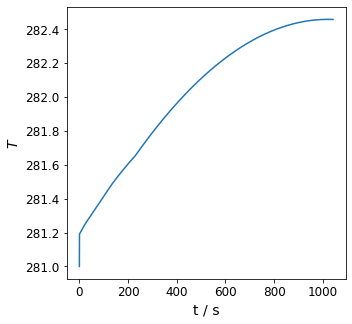

In [5]:
plt.figure(figsize=[5,5])
plt.plot(sol.t,sol.y[1])
plt.xlabel('t / s', size = 14)
plt.ylabel('$T$', size = 14)
plt.tick_params(labelsize=12)
plt.show()

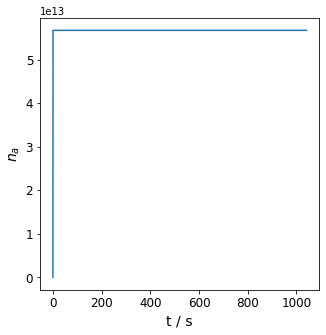

In [6]:
plt.figure(figsize=[5,5])
plt.plot(sol.t,sol.y[0])
plt.xlabel('t / s', size = 14)
plt.ylabel('$n_a$', size = 14)
plt.tick_params(labelsize=12)
plt.show()

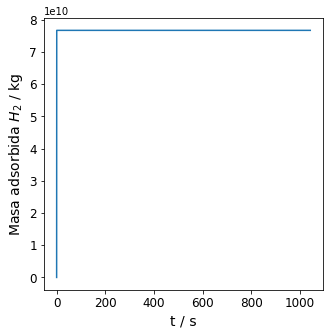

In [7]:
m_H2 = sol.y[0] * M_H2 * m_s

plt.figure(figsize=[5,5])

plt.plot(sol.t,m_H2)
plt.xlabel('t / s', size = 14)
plt.ylabel('Masa adsorbida $H_2$ / kg', size = 14)
# plt.xlim([0,20])
plt.tick_params(labelsize=12)
plt.show()

Sugerencia:
* Partir validando la presión
* Si las ecuaciones se ven bien y la solución no se ve bien, probablemente es un problema del método numérico de integración o el timestep (delta t). Averiguar como se puede controlar el timestep.

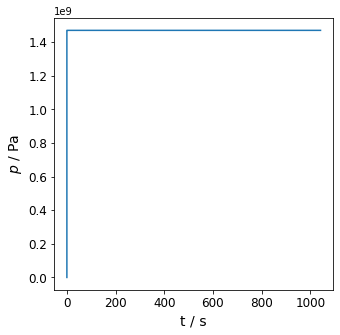

In [8]:
plt.figure(figsize=[5,5])
plt.plot(sol.t,sol.y[2])
plt.xlabel('t / s', size = 14)
plt.ylabel('$p$ / Pa', size = 14)
# plt.xlim([0,20])
plt.tick_params(labelsize=12)
plt.show()

In [9]:
# b * np.exp(-(zeta*xi)/(theta))**b * n_0*zeta*((zeta*xi)/theta)**(-1+b) * dp_dt - b * np.exp(-(zeta*xi)/(theta))**b * n_0*zeta*((zeta*xi)/theta)**(-1+b) * ((zeta*beta*xi)/(theta**2) + (R*xi)/(theta)) * dT_dt

[0.00000000e+00 2.10796811e-08 4.21593622e-08 ... 2.10796178e-02
 2.10796389e-02 2.10796600e-02]


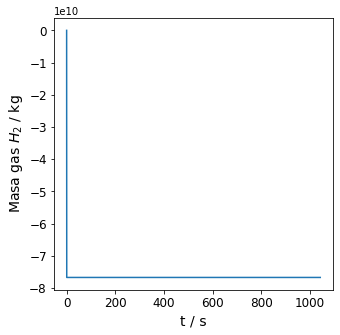

In [10]:
# Moles totales
new_m_t = m_dot * t_range
print(new_m_t)

m_g_f = new_m_t - m_H2

plt.figure(figsize=[5,5])

plt.plot(sol.t,m_g_f)
plt.xlabel('t / s', size = 14)
plt.ylabel('Masa gas $H_2$ / kg', size = 14)
# plt.xlim([0,20])
plt.tick_params(labelsize=12)
plt.show()

Pasos

Determinar dn_dt: revisar que ese valor sea $> 0$ y menor a $n_a$, tambien debe ser menor a $m_dot$.

Simplificar el problema, si $Q_{arld} = 0$, en ese caso revisar si la física hace sentido.

Re leer el paper para verificar si nos estamos olvidando de algo.

Volver a plantear el sistema, en cada tiempo hay un m_t(t)
